In [1]:
import numpy as np
import networkx as nx
import collections

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.cluster import SpectralClustering
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.cluster import KMeans
from scipy import sparse 
from scipy import special
from scipy import optimize
import copy
import tqdm
import itertools
import time
import seaborn as sns 

In [37]:
G = nx.read_adjlist('cora.cites')
labels = {}
with open('cora.content') as fh:
    for line in fh:
        cols = line.strip().split('\t')
        labels[cols[0]] = cols[-1]
class_map = {'Case_Based': 4,
 'Genetic_Algorithms': 2,
 'Neural_Networks': 0,
 'Probabilistic_Methods': 1,
 'Reinforcement_Learning': 5,
 'Rule_Learning': 6,
 'Theory': 3}
labels = {k: class_map[v] for k, v in labels.items()}
graph = nx.subgraph(G, labels.keys())
nx.set_node_attributes(G, labels, 'label')
y = np.zeros((graph.number_of_nodes(), len(class_map)))
for i, node in enumerate(G.nodes(data=True)):
    label = node[1]['label']
    y[i, label - 1] = 1

print("Number of nodes = %d" % G.number_of_nodes())

Number of nodes = 2708


In [38]:
collections.Counter(list(labels.values()))

Counter({0: 818, 6: 180, 5: 217, 1: 426, 3: 351, 2: 418, 4: 298})

In [40]:
classes_01 = [x for x,y in G.nodes(data=True) if y['label'] in [1,2]]
G_01 = nx.subgraph(G, classes_01)
print("Number of nodes in two biggest classes: %d" % G_01.number_of_nodes())

Number of nodes in two biggest classes: 844


In [5]:
def neg(x):
    if x == 0:
        return 1
    else:
        return 0
    
def checkSign(vector):
    labels_pred = np.zeros(len(vector))
    for i in range(len(vector)):
        if (vector[i]<0):
            labels_pred[i] = 1
    return labels_pred


def GetAccuracy(G, labels_pred):
    ground_labels_vals = set(nx.get_node_attributes(G, 'label').values())
    label_map = dict(zip(ground_labels_vals, range(len(ground_labels_vals))))
    ground_labels = list(nx.get_node_attributes(G, 'label').values())
    ground_labels = [label_map[v] for v in ground_labels]
    neg_labels_pred = list(map(neg, labels_pred))
        
    return max(accuracy_score(labels_pred, ground_labels), accuracy_score(neg_labels_pred, ground_labels))

def sp_real_eigsort(A, k = 10, which = 'SR'):
    vals, vecs = sparse.linalg.eigs(A, k = k, which = which)
    idx = np.real(vals).argsort()
    
    return vals[idx], vecs[:, idx]

#     if isinstance(labels_pred, dict):
#         ground_labels_dict = nx.get_node_attributes(self, 'ground_label')
#         ground_labels = [ground_labels_dict[x] for x in labels_pred.keys()]
#         neg_labels_pred_list = [neg(v) for k, v in labels_pred.items()]
#         labels_pred_list = [v for k, v in labels_pred.items()]

#         # print(ground_labels)

#         return max(accuracy_score(labels_pred_list, ground_labels), accuracy_score(neg_labels_pred_list, ground_labels))

In [7]:
laplacian_matrix = nx.normalized_laplacian_matrix(G_01)
n = G_01.number_of_nodes()
vals, vecs = sp_real_eigsort(A = laplacian_matrix.asfptype(), k = int(0.1 * n), which = 'SR')
accs = []
spectra = []
vec_idxs = range(len(vals))
for i in vec_idxs:
    vector = vecs[:,i]
    vector = vector.astype('float64')
    labels_pred = checkSign(vector)
    accuracy = GetAccuracy(G_01, labels_pred)
    accs += [accuracy]
    spectra += [vals[i]] 

/user/abobu/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


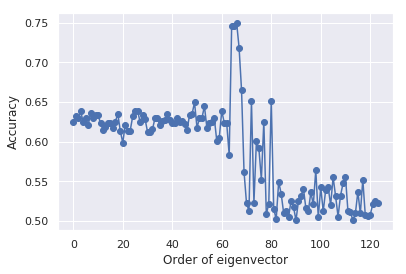

/user/abobu/home/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


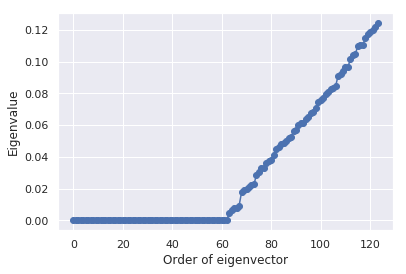

/user/abobu/home/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


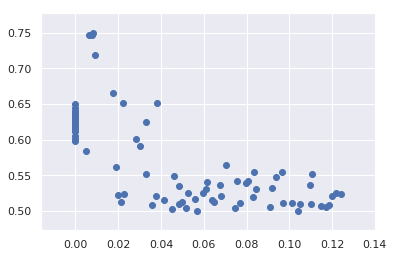

In [8]:
sns.set()
plt.plot(vec_idxs, accs, marker='o')
plt.xlabel("Order of eigenvector")
plt.ylabel("Accuracy")
plt.savefig('cora-01-classes-acc-over-egv.png')
plt.show()

plt.plot(vec_idxs, spectra, marker='o')
plt.xlabel("Order of eigenvector")
plt.ylabel("Eigenvalue")
plt.savefig('cora-01-classes-spectrum.png')
plt.show()

plt.scatter(spectra, accs, marker = 'o')
plt.show()

In [ ]:
vals[42]

In [ ]:
labels_pred = checkSign(vecs[:, 42])
accuracy = GetAccuracy(G_01, labels_pred)
print(accuracy)

In [44]:
laplacian = nx.normalized_laplacian_matrix(G_01).toarray()
nx.number_connected_components(G_01)
# np.count_nonzero(~np.isfinite(laplacian))
# laplacian.shape

62

/user/abobu/home/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


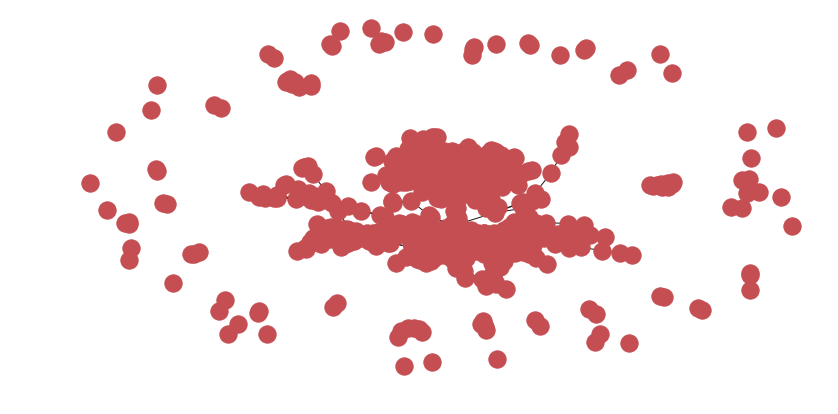

In [46]:
fig, ax1 = plt.subplots(1, 1, sharey = True, figsize=(14, 7))
pos = nx.spring_layout(G_01)
nx.draw(G_01, pos, ax1)
plt.show()
plt.close()

In [42]:
clustering = SpectralClustering(n_clusters = 2,
                                assign_labels = "discretize",
                                affinity = 'precomputed',
                                random_state = 42).fit(laplacian)

/user/abobu/home/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/user/abobu/home/anaconda3/lib/python3.7/site-packages/scipy/sparse/csgraph/_laplacian.py:120: RuntimeWarning: invalid value encountered in sqrt
  w = np.where(isolated_node_mask, 1, np.sqrt(w))


ValueError: array must not contain infs or NaNs

In [15]:
clustering.labels_

array([0, 1, 0, ..., 1, 0, 1])

In [16]:
GetAccuracy(G_01, clustering.labels_)

0.52491961414791